## Predict fluctuations in currency quote

Let's try build model with help of [Prophet](https://facebookincubator.github.io/prophet/) to prеditi fluctuations in currency quotes. For current example I took currency pair UAH/USD for date range 2012-2017.

In [36]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from datetime import datetime

from sklearn.metrics import mean_absolute_error, mean_squared_error

from fbprophet import Prophet

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go

import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
init_notebook_mode(connected = True)

def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)

    fig = {'data': data, 'layout': {'title': title}}
    iplot(fig, show_link=False)

### Getting data

In [38]:
# you can download any date range from the yahoo
# trend_df = web.DataReader('UAH=X', 'yahoo', datetime(2012, 1, 1))

trend_df = pd.read_csv('data/uah_usd_12_17.csv')

In [39]:
# set index for a future manipulation with dates
trend_df.Date = trend_df.Date.apply(lambda d: pd.to_datetime(d))
trend_df.set_index('Date', inplace=True);

In [40]:
trend_df.shape

(1459, 6)

In [41]:
trend_df.describe()

,Open,High,Low,Close,Volume,Adj Close
count,1459.000000,1459.000000,1459.000000,1459.000000,1459.0,1459.000000
mean,16.163636,16.255302,16.097441,16.161064,0.0,16.161064
std,7.788577,7.863250,7.735020,7.789680,0.0,7.789680
min,7.867000,7.893100,7.867000,7.858500,0.0,7.858500
25%,8.040300,8.044900,8.038750,8.044800,0.0,8.044800
50%,12.946000,13.072000,12.806000,12.932000,0.0,12.932000
75%,24.735000,24.782000,24.629500,24.719500,0.0,24.719500
max,33.901000,33.901000,27.671000,33.499000,0.0,33.499000


In [42]:
trend_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1459 entries, 2012-01-02 to 2017-08-07
Data columns (total 6 columns):
Open         1459 non-null float64
High         1459 non-null float64
Low          1459 non-null float64
Close        1459 non-null float64
Volume       1459 non-null int64
Adj Close    1459 non-null float64
dtypes: float64(5), int64(1)
memory usage: 79.8 KB


In [43]:
plotly_df(trend_df[['Open', 'High', 'Low', 'Adj Close']], title='UAH/USD 2012-2017')

### Data cleaning

#### Get rid from outliers

According to documentation of Prophet, the best way to handle outliers is to remove them - Prophet has no problem with missing data.

In [44]:
trend_df.loc[
    (trend_df.index > datetime(2014, 2, 20)) & 
    (trend_df.index < datetime(2014, 3, 10)) & 
    (trend_df['Adj Close'] > 9.5), 
    'Adj Close'
] = None

In [45]:
trend_df.loc[
    (trend_df.index > datetime(2014, 3, 20)) & 
    (trend_df.index < datetime(2014, 4, 30)) & 
    (trend_df['Adj Close'] > 11.5), 
    'Adj Close'
] = None

In [46]:
trend_df.loc[
    (trend_df.index > datetime(2014, 9, 18)) & 
    (trend_df.index < datetime(2014, 10, 10)) & 
    (trend_df['Adj Close'] > 13), 
    'Adj Close'
] = None

In [47]:
trend_df.loc[
    (trend_df.index > datetime(2015, 2, 1)) & 
    (trend_df.index < datetime(2015, 2, 10)) & 
    (trend_df['Adj Close'] > 20), 
    'Adj Close'
] = None

In [48]:
trend_df.loc[
    (trend_df.index > datetime(2015, 2, 1)) & 
    (trend_df.index < datetime(2015, 3, 20)) & 
    (trend_df['Adj Close'] > 24), 
    'Adj Close'
] = None

In [49]:
plotly_df(trend_df[['Adj Close']], title='Cleaned data')

### Add holidays

Documentation about [holidays](https://facebookincubator.github.io/prophet/docs/holiday_effects.html)

In [50]:
holidays = pd.DataFrame({
  'holiday': 'national',
  'ds': pd.to_datetime([
      '2012-01-02', '2013-01-01', '2014-01-01', '2015-01-01', '2016-01-01', '2017-01-02', 
      '2012-01-09', '2013-01-07', '2014-01-02', '2016-01-02', '2016-01-07', '2017-01-09',
      '2012-03-08', '2013-01-01', '2014-01-03', '2015-01-07', '2016-01-08', '2017-03-08',
      '2012-03-09', '2013-03-08', '2014-01-06', '2015-01-08', '2016-03-07', '2017-03-08',
      '2012-04-16', '2013-05-01', '2014-01-07', '2015-01-09', '2016-03-08', '2017-04-17',
      '2012-04-30', '2013-05-02', '2014-03-10', '2015-03-09', '2016-05-02', '2017-05-01',
      '2012-05-01', '2013-05-03', '2014-04-21', '2015-04-13', '2016-05-03', '2017-05-02',
      '2012-05-02', '2013-05-06', '2014-05-01', '2015-05-01', '2016-05-09', '2017-05-08',
      '2012-05-09', '2013-05-09', '2014-05-02', '2015-05-04', '2016-06-20', '2017-05-09',
      '2012-06-04', '2013-05-10', '2014-05-09', '2015-05-11', '2016-06-27', '2017-06-05',
      '2012-06-28', '2013-06-24', '2014-06-30', '2015-06-01', '2016-06-28', '2017-06-28',
      '2012-06-29', '2013-06-28', '2014-08-25', '2015-06-29', '2016-08-24', '2017-08-24',
      '2012-08-24', '2013-08-26',               '2015-08-24', '2016-10-14', '2017-08-25',
      '2012-12-31',                             '2015-10-14',               '2017-10-16',
  ]),
  'lower_window': 0,
  'upper_window': 1,
})

### Cross validation

For cross validation let's take last 60 days

In [51]:
predictions = 60

train_df = trend_df[:-predictions]
train_df.reset_index(inplace=True)

train_df.rename(columns={'Date': 'ds', 'Adj Close': 'y', 'High': 'yhat_upper', 'Low': 'yhat_lower'}, inplace=True)

/home/levabd/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2844: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [52]:
train_df[['ds', 'y', 'yhat_lower', 'yhat_upper']].tail()

,ds,y,yhat_lower,yhat_upper
1394,2017-05-09,26.2930,26.212,26.280
1395,2017-05-10,26.4450,26.430,26.575
1396,2017-05-11,26.4225,26.400,26.440
1397,2017-05-12,26.4700,26.380,26.495
1398,2017-05-15,26.4350,26.420,26.495


### Build a model

In [53]:
%%time

m = Prophet(changepoint_prior_scale=0.1, holidays=holidays, holidays_prior_scale=18)
m.fit(train_df);

future = m.make_future_dataframe(periods=predictions)

forecast_test = m.predict(future)

CPU times: user 13.9 s, sys: 324 ms, total: 14.2 s
Wall time: 13.1 s


In [54]:
test_df = forecast_test[-predictions:].set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']]

In [55]:
index_list = trend_df[
    (trend_df.index >= test_df.index.min()) & (trend_df.index <= test_df.index.max())
].index.tolist()

In [56]:
# check influence of the holidays
forecast_test[(forecast_test['national']).abs() > 0][['ds', 'national']][-10:]

,ds,national
1388,2017-05-01,-0.034031
1389,2017-05-02,-0.020989
1390,2017-05-03,0.013041
1393,2017-05-08,-0.034031
1394,2017-05-09,-0.020989
1395,2017-05-10,0.013041
1419,2017-06-05,-0.034031
1420,2017-06-06,0.013041
1442,2017-06-28,-0.034031
1443,2017-06-29,0.013041


### Evaluate model

For evaluation let's take [Mean squared error](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) and [Mean absolute error](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html)

In [57]:
print('Mean squared error: {}'.format(
    mean_squared_error(
        trend_df[trend_df.index.isin(index_list)]['Adj Close'].values, 
        test_df[test_df.index.isin(index_list)]['yhat'].values
    )
))

Mean squared error: 0.08575028273760138


In [58]:
print('Mean avsolute error: {}'.format(
    mean_absolute_error(
        trend_df[trend_df.index.isin(index_list)]['Adj Close'].values, 
        test_df[test_df.index.isin(index_list)]['yhat'].values
    )
))

Mean avsolute error: 0.26895408362190276


### Visualizate forecast

Prophet can plot the forecast dataframe. Also you can see the trend, yearly seasonality, and weekly seasonality of the time series. If you include holidays, you’ll see those here, too.

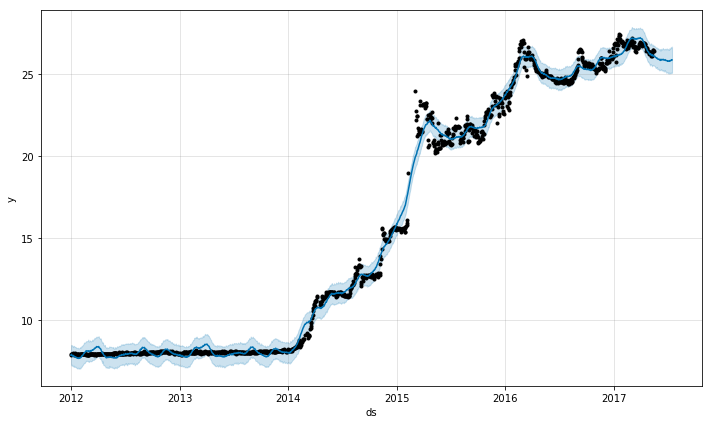

In [59]:
m.plot(forecast_test);

###  Visualizate the forecast components

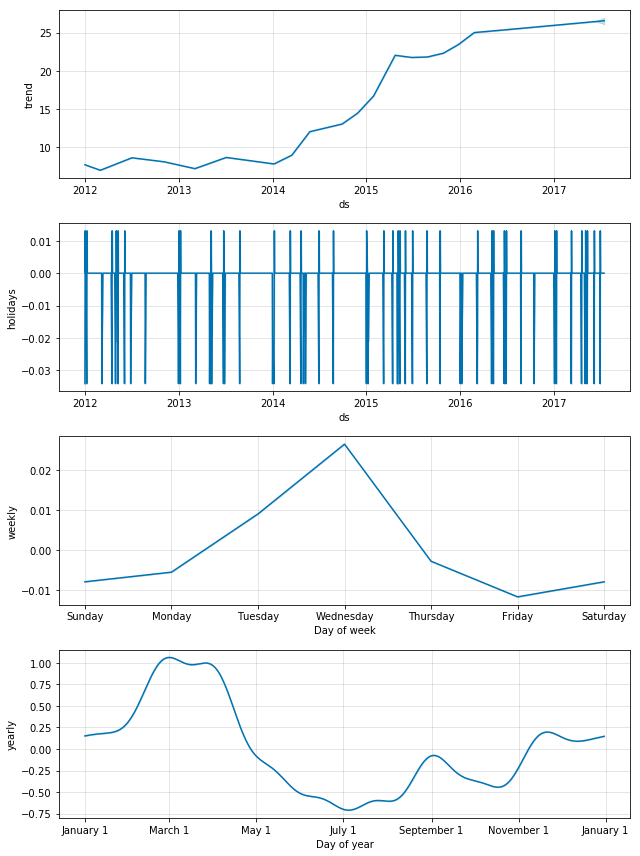

In [60]:
m.plot_components(forecast_test);

### Build forecast for the next 6 months

In [61]:
predict_df = trend_df.copy()
predict_df.reset_index(inplace=True)

predict_df.rename(columns={'Date': 'ds', 'Adj Close': 'y', 'High': 'yhat_upper', 'Low': 'yhat_lower'}, inplace=True)

In [67]:
%%time

m = Prophet(changepoint_prior_scale=0.1, holidays=holidays, holidays_prior_scale=18)
m.fit(predict_df);

future = m.make_future_dataframe(periods=180)

forecast = m.predict(future)

CPU times: user 13.8 s, sys: 288 ms, total: 14.1 s
Wall time: 9.59 s


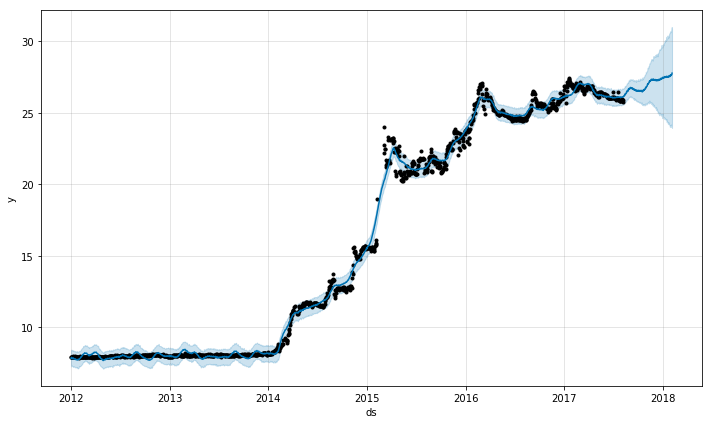

In [68]:
m.plot(forecast);

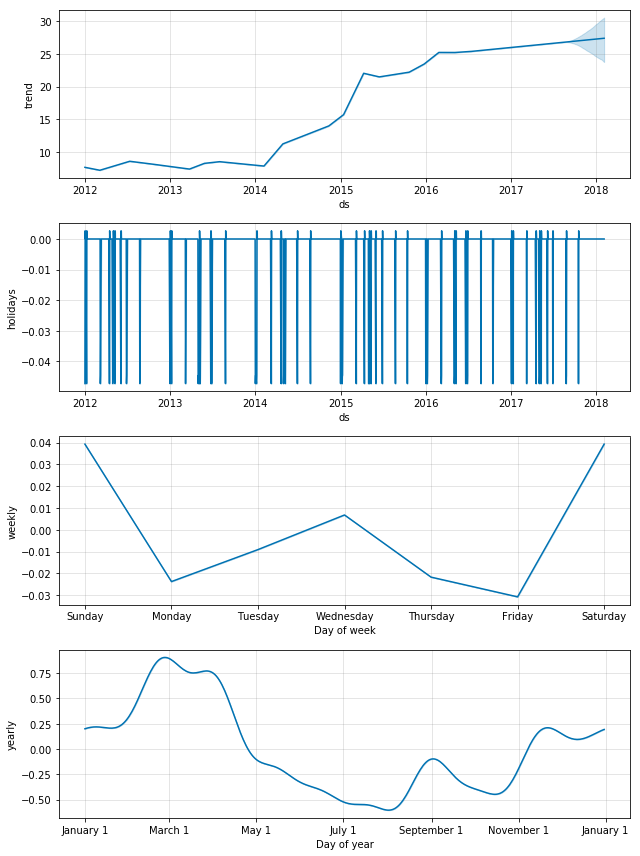

In [69]:
m.plot_components(forecast);

### Visualizate the forecast in the details

In [70]:
forecast[['ds', 'yhat_upper', 'yhat', 'yhat_lower']].tail()

,ds,yhat_upper,yhat,yhat_lower
1634,2018-01-30,30.647277,27.633157,24.190555
1635,2018-01-31,30.777968,27.670452,24.021110
1636,2018-02-01,30.972396,27.665399,24.146222
1637,2018-02-02,31.011140,27.681893,24.005347
1638,2018-02-03,30.864770,27.779572,23.948933


In [72]:
forecast_df = forecast[['ds', 'yhat_upper', 'yhat', 'yhat_lower']][-180:]

forecast_df.set_index('ds', inplace=True)
forecast_df.rename(
    columns={'yhat_upper': 'forecast_upper', 'yhat': 'forecast', 'yhat_lower': 'forecast_lower'}, 
    inplace=True
)

plotly_df(forecast_df, title='The forecast in the details')